# Question 8 : Sarsa
Copying the current network parameters to the target network every 5 episodes and acting $\epsilon$-greedily in target network.

# Running this file
Run the until stopped and proceed as instucted


In [1]:
import sys
import math
import random
import pdb
import numpy as np
import tensorflow as tf
import gym
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import os
from copy import deepcopy
warnings.filterwarnings('ignore')

In [2]:
def eps_greed(q,epsilon=0.05):
    u = np.random.uniform(0,1,1)
    if u <= epsilon:

        if np.random.uniform(0,1,1)>0.5:
            act = 0
        else:
            act = 1
    else:
        act = np.argmax(q)
        
    return act

In [3]:
# create a network that  will be used to take the loss.
def q_net_opt(state,action, weights, biases, q_target, alpha, discount = 0.99):

    hidden = tf.nn.relu(tf.matmul(state, weights['w1']) + biases['b1'])
    q = tf.matmul(hidden, weights['w2']) + biases['b2']

    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    diff = tf.square(q_target - qa) / 2
    loss = tf.reduce_mean(diff)
    opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

In [4]:
# create a network that  will be used to take the loss.
def q_target(next_state, weights, biases, reward,rand_states, discount = 0.99,epsilon = 0.05):
    
    hidden = tf.nn.relu(tf.matmul(next_state, weights['w1']) + biases['b1'])
    q_prime = tf.matmul(hidden, weights['w2']) + biases['b2']
    # act epsilon greediliy in target net
    u = np.random.uniform(0,1,1)
    if u <= epsilon:
        q_prime_max =  tf.reshape(tf.gather_nd(q_prime, rand_states), [-1, 1])
         
    else:
        q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])

    delta = reward + 1   # don't boostrap if state is terminal
    target = reward + discount * tf.multiply(delta, tf.stop_gradient(q_prime_max))
    return target

In [5]:
# reference
def get_q_optimize2(state, next_state,action, alpha, reward, discount = 0.99):

    weights = {'w1': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
               'w2': tf.Variable(tf.random_uniform([100, 2], 0, 0.01))}
    biases = {'b1': tf.Variable(tf.random_uniform([100], 0, 0.01)),
              'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}

    hidden = tf.nn.relu(tf.matmul(state, weights['w1']) + biases['b1'])
    q = tf.matmul(hidden, weights['w2']) + biases['b2']

    hidden = tf.nn.relu(tf.matmul(next_state, weights['w1']) + biases['b1'])
    q_prime = tf.matmul(hidden, weights['w2']) + biases['b2']

    #print(type(q_prime))
    #b = tf.select(q_prime>0.1)
    delta = reward + 1   # don't boostrap if state is terminal
    q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])
    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    diff = tf.square(reward + discount * tf.multiply(delta, tf.stop_gradient(q_prime_max)) - qa) / 2
    loss = tf.reduce_mean(diff)
    #opt = tf.train.RMSPropOptimizer(alpha, 0.95, 0.0, 1e-7).minimize(loss)
    #hidden
    #opt = tf.train.RMSPropOptimizer(alpha, 0.99, 0.0, 1e-6).minimize(loss)
    opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

# Do not run these cells...
Continue to load data below to load model and get return and length of episodes

In [7]:
# Training parameters
max_eps_length = 300
discount = 0.99
alpha = 0.001
n_episodes = 2000
freq = n_episodes/100
epsilon = 0.05
sample_episodes = 10
episode_lengths = []
episode_returns = []

In [8]:
# Need to save the model, weights and biases varibles

# Suggested Directory to use
save_MDir = 'new_models/A8/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

save_model = os.path.join(save_MDir,'sarsa_model')

In [9]:
q_weights = {'w1': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
       'w2': tf.Variable(tf.random_uniform([100, 2], 0, 0.01))}
q_biases = {'b1': tf.Variable(tf.random_uniform([100], 0, 0.01)),
      'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}
qt_weights = {'w1': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
       'w2': tf.Variable(tf.random_uniform([100, 2], 0, 0.01))}
qt_biases = {'b1': tf.Variable(tf.random_uniform([100], 0, 0.01)),
      'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}


In [10]:
# copy variables:
copy_w1 = qt_weights['w1'].assign(q_weights['w1'])
copy_w2 = qt_weights['w2'].assign(q_weights['w2'])
copy_b1 = qt_biases['b1'].assign(q_biases['b1'])
copy_b2 = qt_biases['b2'].assign(q_biases['b2'])


In [31]:
start = time.time()
replay_buffer = np.load("./replay_buffer_data.npy")
replay_buffer = replay_buffer[:1000,:]
batch_size = 64
sample_episodes = 15
n_episodes = 2000
freq = n_episodes/100
count = 0
counting = 0    
replay_count = 0
# for each episode in 2000 episodes we optimize the q values. 
#print('----Starting iteration number: {}----'.format(iteration+1))
#start_iteration = time.time()

episode_loss = []
total_episode_lengths = []
total_episode_returns = []
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state = tf.placeholder("float", [None, 4], name = 'state')
action = tf.placeholder(tf.int32, [None, 2], name = 'actions')
next_state = tf.placeholder("float", [None, 4], name = 'next_states')
reward = tf.placeholder("float", [None, 1], 'rewards')
target = tf.placeholder("float", [None,1],'target')
rand_states = tf.placeholder("float", [None,2],'rand_states')

optimize,q,loss = q_net_opt(state,action, q_weights, q_biases, target, alpha, discount = 0.99)
tar = q_target(next_state, qt_weights, qt_biases, reward,rand_states, discount = 0.99)
#optimize,q,loss = get_q_optimize2(state, next_state,action, alpha, reward, discount)

terminate_episode = False
init = tf.global_variables_initializer()
saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)


with tf.Session() as sess:
    sess.run(init)

    for i_episode in range(n_episodes):
        #----------------------------------Here is where we copy
        if i_episode % 5 == 0:
            print('Copying variables at episode {}'.format(i_episode))
            sess.run([copy_w1,copy_w2,copy_b1,copy_b2])
            
        if i_episode % freq == 0:
            print('Now runnning episode:{}'.format(i_episode+1))
            print('Total run time so far is: {}'.format(time.time()-start))
        # Every 10 episodes we take 10 sample runs and report their average lengths
        if i_episode % freq == 0:
            
            sample_episode_lengths = []
            sample_episode_returns = []            
            for _ in range(sample_episodes):
                s = env.reset()
                for t in range(max_eps_length):
                    cur_q = sess.run(q, feed_dict={state:s.reshape(1,-1)})
                    a = eps_greed(cur_q)
                    s_prime,re,done,info = env.step(a)
                    

                    if done:
                        #print('episode finished')
                        re = -1
                        sample_episode_lengths.append(t+1)
                        sample_episode_returns.append(-1*discount**t)
                        break

                    s = s_prime
            total_episode_lengths.append(np.mean(sample_episode_lengths))
            total_episode_returns.append(np.mean(sample_episode_returns))


        s = env.reset()
        for t in range(max_eps_length):
            cur_q = sess.run(q, feed_dict={state:s.reshape(1,-1)})
            a = eps_greed(cur_q)
            s_prime,re,done,info = env.step(a)
#             if replay_count == 500:
#                 print(replay_buffer[:20,:])
            if done:
                re = -1
                #print(s_prime)
                replay_buffer[replay_count,:] = np.append(np.append(s.reshape(1,-1), np.asarray([a, re])), s_prime.reshape(1,-1))
                replay_count +=1
                if replay_count == replay_buffer.shape[0]:
                    replay_count =0
                episode_lengths.append(t+1)
                episode_returns.append(-1*discount**t)
                terminate_episode = True
                if i_episode % freq == 0:
                    print('For episode {} the length is: {}\n'.format( i_episode+1,t+1))
            else:
                re = 0
                replay_buffer[replay_count,:] = np.append(np.append(s.reshape(1,-1), np.asarray([a, re])), s_prime.reshape(1,-1))
                replay_count +=1
                if replay_count == replay_buffer.shape[0]:
                    replay_count =0
            
            # Now I need to put in the batch. ie copy orig data shuffle, take first 64 samples, dont  fprget to label actinos
            # optimize and repeat
            shuffled_data = deepcopy(replay_buffer)
            np.random.shuffle(shuffled_data)
            batch = shuffled_data[:batch_size,:]
            act = batch[:, 4].reshape(-1, 1)
            act = np.append(np.arange(len(act)).reshape(-1, 1), act, axis=1)
            rand_s =np.random.binomial(1, 0.5, 32).reshape(-1,1)
            rand_s = np.append(np.arange(len(rand_s)).reshape(-1, 1), rand_s, axis=1)
            
            qt_dict = {next_state: batch[:,-4:], reward : batch[:,5].reshape(-1,1), rand_states: rand_s}
            q_tar = sess.run(tar, qt_dict)
            #print(q_tar.shape)
            
            q_dict = {state : batch[:,:4],action:act,
                         reward : batch[:,5].reshape(-1,1), target: q_tar.reshape(-1,1)
                        }
            #this_dict = {state:s.reshape(-1,1), next_state:s_prime.reshape(-1,1), action:a, reward:re}
            opt, ls = sess.run([optimize,loss],q_dict)

            if  terminate_episode == True:
                count +=1
                terminate_episode = False
                break
            s = s_prime
            
            #if replay_count == 0:
            #print(replay_buffer[:100,:])
        if i_episode %freq == 0:
                episode_loss.append(ls)
        
    
    print('Saving model...')
    saver.save(sess= sess, save_path = save_model)

total_episode_lengths = np.asarray(total_episode_lengths).reshape(-1,1)
total_episode_returns = np.asarray(total_episode_returns).reshape(-1,1)
episode_loss = np.asarray(episode_loss).reshape(-1,1)

saved_data  = np.concatenate((total_episode_lengths, total_episode_returns, episode_loss), axis=1)
filename = './results/A8_results.csv'
#np.savetxt(filename, saved_data, delimiter=' ,')
print('Total run time is: {}'.format(time.time()-start))

[2017-04-07 22:04:02,247] Making new env: CartPole-v0


Copying variables at episode 0
Now runnning episode:1
Total run time so far is: 1.438953161239624
For episode 1 the length is: 10

Copying variables at episode 5
Copying variables at episode 10
Copying variables at episode 15
Copying variables at episode 20
Now runnning episode:21
Total run time so far is: 2.974951982498169
For episode 21 the length is: 60

Copying variables at episode 25
Copying variables at episode 30
Copying variables at episode 35
Copying variables at episode 40
Now runnning episode:41
Total run time so far is: 10.98388671875
For episode 41 the length is: 140

Copying variables at episode 45
Copying variables at episode 50
Copying variables at episode 55
Copying variables at episode 60
Now runnning episode:61
Total run time so far is: 18.103711128234863
For episode 61 the length is: 121

Copying variables at episode 65
Copying variables at episode 70
Copying variables at episode 75
Copying variables at episode 80
Now runnning episode:81
Total run time so far is: 25

In [ ]:
import pandas as pd
df = pd.read_csv(csv_file)

In [19]:
saved_data

array([[ 12.6       ,  -0.89013378,   0.04656745]])

In [23]:
sum(i >= 200 for i in saved_data[:,0])

51

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


20.0


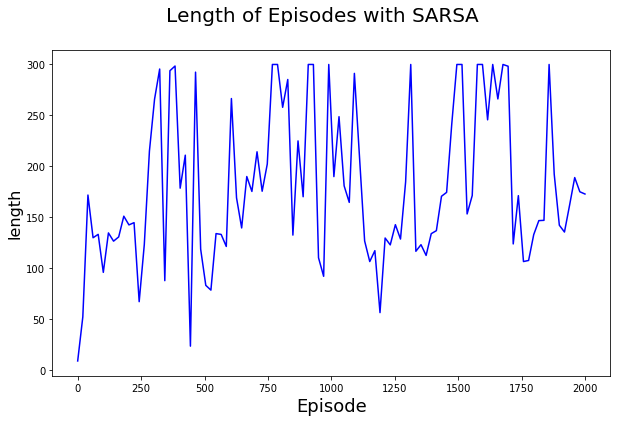

In [32]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,0],'b')# plotting t,a separately 

fig.suptitle('Length of Episodes with SARSA', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('length', fontsize=16)
plt.show()
#fig.savefig('./results/pics/A8_lengths_p.jpg')

20.0


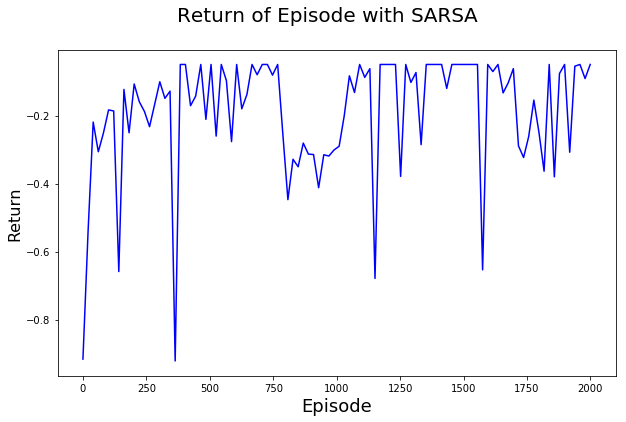

In [22]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,1],'b')# plotting t,a separately 

fig.suptitle('Return of Episode with SARSA', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.show()
fig.savefig('./results/pics/A8_returns.jpg')

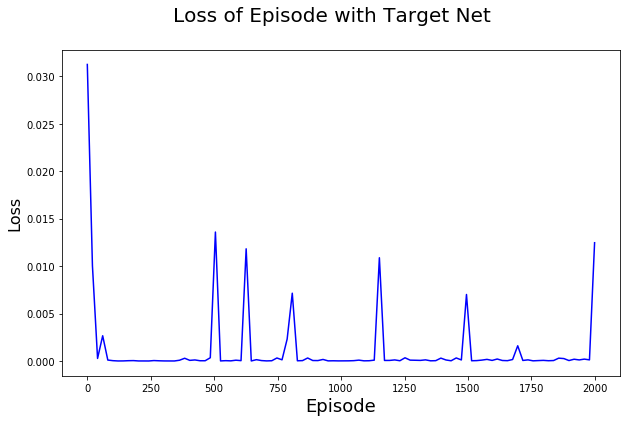

In [23]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
plt.plot(t,saved_data[:,2],'b')# plotting t,a separately 

fig.suptitle('Loss of Episode with SARSA ', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.show()
fig.savefig('./results/pics/A8_loss.jpg')

# Load Model
Load the model of the best learning rate. Output the Average return and episode length

In [6]:
alpha = 0.001
file_name = "A8_large%i.ckpt" %(int(alpha*100000))
save_MDir = 'new_models/A8/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
print(save_model)

new_models/A8/A8_large100.ckpt


In [7]:
def test_epoch(sess, test_episodes):   
    e_length = []
    e_return = []
    av_len = []
    av_ret = []
    for _ in range(test_episodes):
        s = env.reset()
        
        for t in range(300):
            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
            #ac_greedily
            a = np.argmax(this_q)

            s_prime, rwd, done, info = env.step(a)

            if done:
                e_length.append(t+1)
                e_return.append(-1 * discount**t)
                break
            s = s_prime

    #av_len.append(np.mean(np.array(episode_length)))
    #av_ret.append(np.mean(np.array(episode_return)))
    return e_length, e_return

In [8]:
def get_placeholders():
    state = tf.placeholder("float", [None, 4], name = 'state')
    action = tf.placeholder(tf.int32, [None, 2], name = 'actions')
    next_state = tf.placeholder("float", [None, 4], name = 'next_states')
    reward = tf.placeholder("float", [None, 1], 'rewards')
    target = tf.placeholder("float", [None,1],'target')
    return state, action, next_state, reward, target

In [10]:
tf.reset_default_graph()
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

discount = 0.99

state, action, next_state, reward,target = get_placeholders()
optimize,q,loss = get_q_optimize2(state, next_state,action, alpha, reward, discount)
init  = tf.global_variables_initializer()
test_episodes = 50
"""---------------- restore model after training  --------------------------"""
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    print(save_model)
    saver.restore(sess = sess, save_path= save_model)
    print("Restored values for learning rate: ",alpha)
    restored_length, restored_return = test_epoch(sess,50)
    print('The average length of episode is: {} with std: {} '.format(np.mean(restored_length),np.std(restored_length)))
    print('The average return of episode is: {} with std: {} '.format(np.mean(restored_return),np.std(restored_return)))


[2017-04-08 14:49:45,409] Making new env: CartPole-v0


new_models/A8/A8_large100.ckpt
Restored values for learning rate:  0.001
The average length of episode is: 297.1 with std: 11.703418304068261 
The average return of episode is: -0.05142893491129464 with std: 0.00804832577107489 
